# Programming Project #2: Image Quilting

## CS445: Computational Photography


In [1]:
# from google.colab import drive
# drive.mount('/content/drive')

In [2]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import os
from random import random
import time

# modify to where you store your project data including utils.py
datadir = "./"

utilfn = datadir + "utils.py"
!cp "$utilfn" .
samplesfn = datadir + "samples"
!cp -r "$samplesfn" .
import utils

cp: './utils.py' and './utils.py' are the same file
cp: './samples' and './samples' are the same file


In [3]:
from utils import cut # default cut function for seam finding section

### Part I: Randomly Sampled Texture (10 pts)

In [4]:
import numpy as np
import random

def quilt_random(sample_img, out_size, patch_size):
    height, width, _ = sample_img.shape
    black_image = np.zeros((out_size, out_size, 3), dtype=np.uint8)

    # keeping track of the current place we are in the black image
    current_x = 0
    current_y = 0

    # the farthest we can go on the x or y axis
    stopping_depth = out_size - patch_size

    # while we are not at the bottom of the image (this is most important as we dynamically will check and update our current_x)
    while current_y <= stopping_depth:
        # Check if we can still fit a patch horizontally
        if current_x <= stopping_depth:  
            # First, we want to get the random sample
            start_x = random.randint(0, width - patch_size)
            start_y = random.randint(0, height - patch_size)

            # Extract the patch from the sample image
            current_sample = sample_img[start_y:start_y + patch_size, start_x:start_x + patch_size]

            # Place the sample in the black image
            black_image[current_y:current_y + patch_size, current_x:current_x + patch_size] = current_sample

            # Move current_x to the right. We know we can do this because we checked to ensure we are not at the stopping depth
            current_x += patch_size
        else:
            # Move to the next row if we've reached the edge of the current row
            current_x = 0
            current_y += patch_size

    return black_image

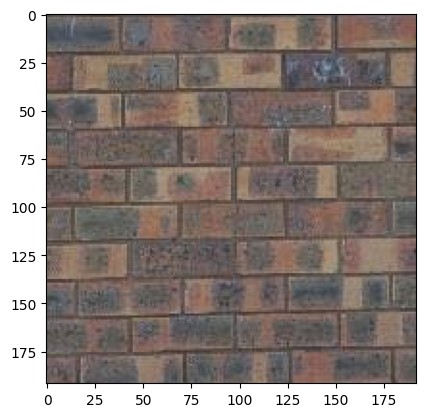

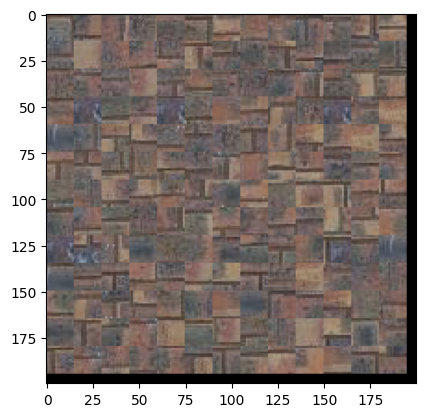

In [5]:
sample_img_fn = 'samples/bricks_small.jpg' # feel free to change
sample_img = cv2.cvtColor(cv2.imread(sample_img_fn), cv2.COLOR_BGR2RGB)
plt.imshow(sample_img)
plt.show()

out_size = 200  # change these parameters as needed
patch_size = 15
res = quilt_random(sample_img, out_size, patch_size)
if res is not None:
    plt.imshow(res)

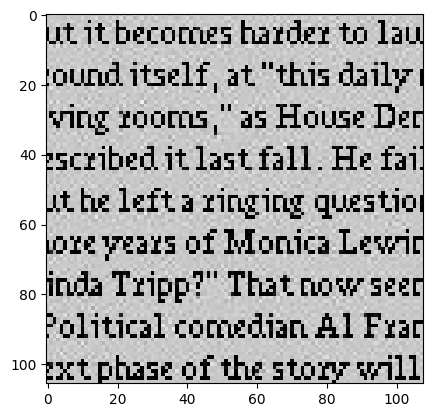

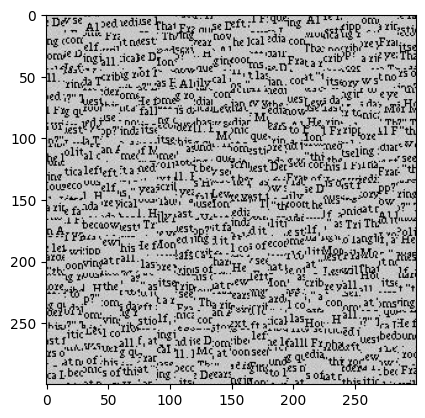

In [6]:
sample_img_fn = 'samples/text_small.jpg' # feel free to change
sample_img = cv2.cvtColor(cv2.imread(sample_img_fn), cv2.COLOR_BGR2RGB)
plt.imshow(sample_img)
plt.show()

out_size = 300  # change these parameters as needed
patch_size = 15
res = quilt_random(sample_img, out_size, patch_size)
if res is not None:
    plt.imshow(res)

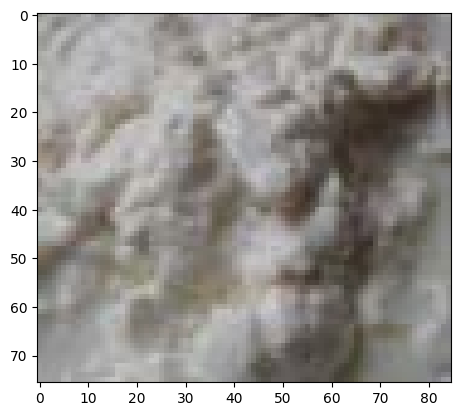

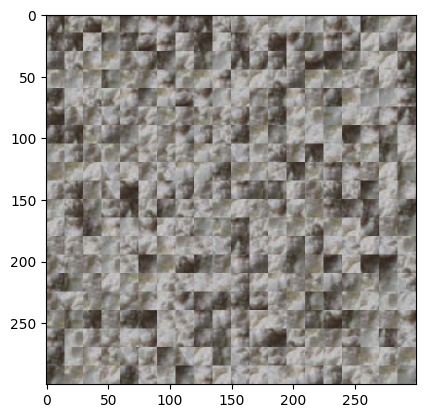

In [9]:
sample_img_fn = 'samples/white_small.jpg' # feel free to change
sample_img = cv2.cvtColor(cv2.imread(sample_img_fn), cv2.COLOR_BGR2RGB)
plt.imshow(sample_img)
plt.show()

out_size = 300  # change these parameters as needed
patch_size = 15
res = quilt_random(sample_img, out_size, patch_size)
if res is not None:
    plt.imshow(res)

### Part II: Overlapping Patches (30 pts)

In [142]:
import random
import numpy as np
import cv2
import matplotlib.pyplot as plt

def quilt_simple(sample_img, out_size, patch_size, overlap, tol):
    height, width, _ = sample_img.shape
    black_image = np.zeros((out_size, out_size, 3), dtype=np.uint8)
    current_x = 0
    current_y = 0
    
    # Step 1: Take a random sample and add it to the top left corner
    current_sample = grab_a_random_sample(sample_img)
    black_image[current_y:current_y + patch_size, current_x:current_x + patch_size] = current_sample
    current_x += patch_size

    # Step 2: Start filling the image using patches
    while current_y < out_size:
        # Check for the next position
        if current_x >= out_size:
            current_x = 0
            current_y += patch_size
            if current_y >= out_size:
                break
        
        # best_ssd_cost = float('inf')
        best_patch = None
        
        mask = create_mask(patch_size, overlap, (patch_size, patch_size, 3))
        best_patch = choose_sample(sample_img,black_image,current_x, current_y, patch_size, mask, overlap, 500)
        black_image[current_y:current_y + patch_size, current_x:current_x + patch_size] = best_patch

        current_x += patch_size  # Move to the right

    return black_image

In [133]:
def grab_a_random_sample(sample_img):
    height, width, _ = sample_img.shape
    start_x = random.randint(0, width - patch_size)
    start_y = random.randint(0, height - patch_size)
    
    current_sample = sample_img[start_y:start_y + patch_size, start_x:start_x + patch_size]
    
    return current_sample

In [134]:
def create_mask(patch_size, overlap, area_to_fill_shape):
    # Assuming area_to_fill is already defined with specific shape
    # Initialize the mask with zeros
    M = np.zeros(area_to_fill_shape, dtype=np.float32)
    
    # Define the overlapping region bounds
    x_overlap_start = patch_size - overlap
    x_overlap_end = patch_size
    
    y_overlap_start = patch_size - overlap
    y_overlap_end = patch_size
    
    # Set the overlapping region to 1
    M[y_overlap_start:y_overlap_end, x_overlap_start:x_overlap_end] = 1
    
    return M

In [143]:
import cv2
import numpy as np

def ssd_patch(I, T, M, overlap):
    """
    Calculates the sum of squared differences (SSD) between a template patch T and the image I,
    using the mask M to define the overlapping region.
    
    Parameters:
    - I : Input image (the image we are sampling from).
    - T : Template patch (the patch we want to match).
    - M : Mask defining the overlapping region (1s where T overlaps with I).
    - overlap : Size of the overlap (not used in this function directly).

    Returns:
    - ssd_cost: An array representing the SSD cost for sampling patches at each pixel position.
    """
    # Calculate the SSD cost as described
    ssd_cost = ((M * T) ** 2).sum() - 2 * cv2.filter2D(I, ddepth=-1, kernel=M * T) + cv2.filter2D(I ** 2, ddepth=-1, kernel=M)

    # Ensure that the output is correctly shaped if needed
    return ssd_cost

In [90]:
def ssd_patch(I,T,M,overlap): 
    
    """
    performs template matching with the overlapping region, computing the cost of sampling each patch, based on the sum of squared differences (SSD) of the overlapping regions of the existing and sampled 
    patch. I suggest using a masked template. The template is the patch in the current output image that is to be filled in (many pixel values will be 0 because they are not filled in yet). The mask has the
    same size as the patch template and has values of 1 in the overlapping region and values of 0 elsewhere. The SSD of the masked template with the input texture image can be computed efficiently using 
    filtering operations. Suppose I have a template T, a mask M, and an image I: then, ssd_cost = ((M*T)**2).sum() - 2 * cv2.filter2D(I, ddepth=-1, kernel = M*T) + cv2.filter2D(I ** 2, ddepth=-1, kernel=M).
    You can compute SSD in this way for each channel and sum the costs over channels. Each pixel of the ssd_cost gives you the cost for sampling a patch centered around that pixel.
    
    """
    ssd_cost = ((M*T)**2).sum() - 2 * cv2.filter2D(I, ddepth=-1, kernel = M*T) + cv2.filter2D(I ** 2, ddepth=-1, kernel=M)
    return ssd_cost

In [146]:
def choose_sample(sample_img,black_image,current_x, current_y, patch_size, mask, overlap, depth):
    """
    should take as input a cost image (each pixel's value is the cost of selecting the patch centered at that pixel) and select a randomly sampled patch with low cost. It's recommended to sort the costs 
    and choose of of the tol smallest costs. So if tol=1, the lowest cost will always be chosen (this is a good way to debug but mainly copies the input texture). If tol=3, one of the three lowest cost 
    patches will be chosen. After a patch is sampled, its pixels should be copied directly into the corresponding position in the output image. Note that it is very easy to make alignment mistakes when 
    computing the cost of each patch, sampling a low-cost patch, and copying the patch from the source to the output. Use an odd value for patch_size so that its center is well-defined. Be sure to 
    thoroughly debug, for example, by checking that the overlapping portion of the copied pixels has the same SSD as the originally computed cost. As a sanity check, try generating a small texture image 
    with tol=1, with the first patch sampled from the upper-left of the source image. This should produce a partial copy of the source image. Once you have this function working, save a result 
    (with higher tolerance for more stochastic texture) generated from the same sample as used for the random method.

    """
    best_ssd_cost = float('inf')
    # Iterate to find the best patch for the current position
    for i in range(depth):
        sample_to_check = grab_a_random_sample(sample_img)
        # Compute the SSD cost
        ssd_cost = ssd_patch(black_image[current_y:current_y + patch_size, current_x:current_x + patch_size], sample_to_check, mask, overlap)

        # Find the minimum SSD value and its position
        min_ssd_value = np.min(ssd_cost)

        # If the current patch is better, update the best patch
        if min_ssd_value < best_ssd_cost:
            best_ssd_cost = min_ssd_value
            best_patch = sample_to_check

    
    return best_patch

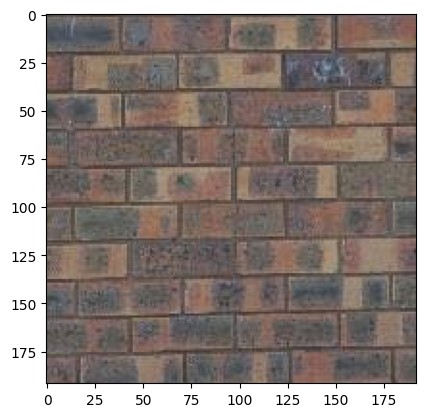

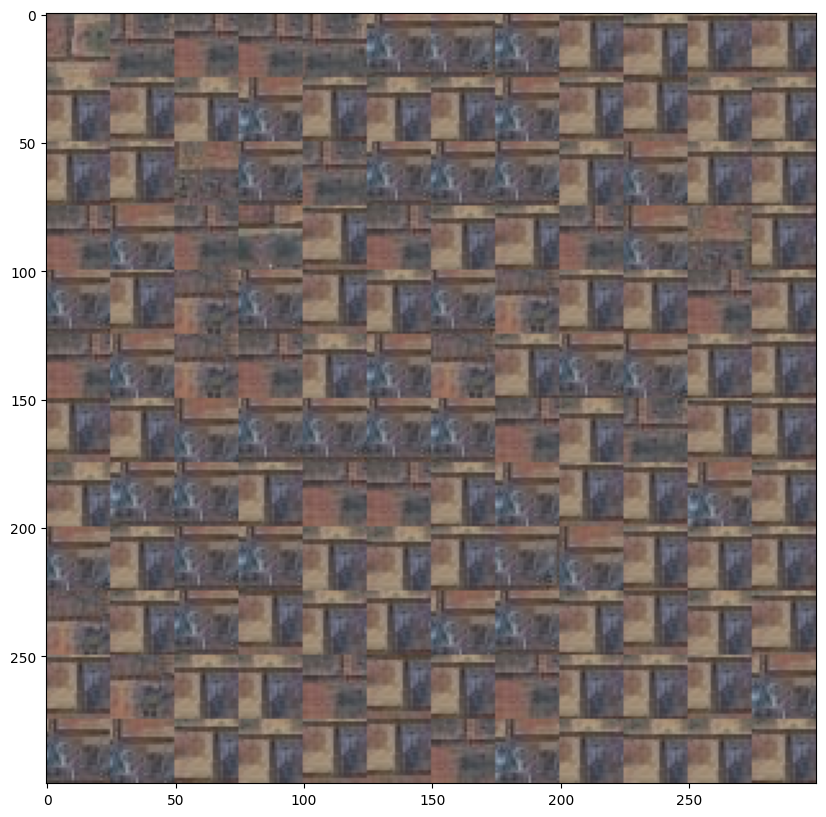

In [147]:
sample_img_fn = 'samples/bricks_small.jpg'
sample_img = cv2.cvtColor(cv2.imread(sample_img_fn), cv2.COLOR_BGR2RGB)
plt.imshow(sample_img)
plt.show()

out_size = 300  # change these parameters as needed
patch_size = 25
overlap = 11
tol = 5
res = quilt_simple(sample_img, out_size, patch_size, overlap, tol) #feel free to change parameters to get best results
if res is not None:
    plt.figure(figsize=(10,10))
    plt.imshow(res)

TODO: understand this code better and comment it out, as well as make it so we select a random min ssd value based on tol. Also, show some examples of the mask being generated and explain the math.

### Part III: Seam Finding (20 pts)


In [ ]:
# optional or use cut(err_patch) directly
def customized_cut(bndcost):
    pass

In [ ]:
def quilt_cut(sample, out_size, patch_size, overlap, tol):
    """
    Samples square patches of size patchsize from sample using seam finding in order to create an output image of size outsize.
    Feel free to add function parameters
    :param sample: numpy.ndarray
    :param out_size: int
    :param patch_size: int
    :param overlap: int
    :param tol: float
    :return: numpy.ndarray
    """


In [ ]:
sample_img_fn = 'samples/bricks_small.jpg'
sample_img = cv2.cvtColor(cv2.imread(sample_img_fn), cv2.COLOR_BGR2RGB)
plt.imshow(sample_img)
plt.show()

out_size = 300  # change these parameters as needed
patch_size = 25
overlap = 11
tol = 5
res = quilt_cut(sample_img, out_size, patch_size, overlap, tol)
if res is not None:
    plt.figure(figsize=(15,15))
    plt.imshow(res)

### Part IV: Texture Transfer (30 pts)

In [ ]:
def texture_transfer(sample, patch_size, overlap, tol, guidance_im, alpha):
    """
    Samples square patches of size patchsize from sample using seam finding in order to create an output image of size outsize.
    Feel free to modify function parameters
    :param sample: numpy.ndarray
    :param patch_size: int
    :param overlap: int
    :param tol: float
    :param guidance_im: target overall appearance for the output
    :param alpha: float 0-1 for strength of target
    :return: numpy.ndarray
    """


In [ ]:
# load/process appropriate input texture and guidance images

patch_size = 25
overlap = 11
tol = 3
alpha = 0.5
res = texture_transfer(texture_img, patch_size, overlap, tol, guidance_img, alpha)

plt.figure(figsize=(15,15))
plt.imshow(res)
plt.show()

### Bells & Whistles

(15 pts) Implement the iterative texture transfer method described in the paper. Compare to the non-iterative method for two examples.

(up to 20 pts) Use a combination of texture transfer and blending to create a face-in-toast image like the one on top. To get full points, you must use some type of blending, such as feathering or Laplacian pyramid blending.

(up to 40 pts) Extend your method to fill holes of arbitrary shape for image completion. In this case, patches are drawn from other parts of the target image. For the full 40 pts, you should implement a smart priority function (e.g., similar to Criminisi et al.).